In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.optimize import linprog

In [3]:
os.chdir(r"C:\Users\jakes\OneDrive\Documents\staffing-forecast-optimization\data")
os.getcwd()

'C:\\Users\\jakes\\OneDrive\\Documents\\staffing-forecast-optimization\\data'

In [30]:
df_hourly = pd.read_csv("hour.csv")
print(df_hourly.head())

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  


In [11]:
hour_labels = [f"{h%12 if h%12 !=0 else 12}{'AM' if h<12 else 'PM'}" for h in range(24)]
hourly_demand = df_hourly.groupby("hr")["cnt"].mean()
hourly_demand.index = hour_labels

In [13]:
capacity_using_registered_users = df_hourly.groupby("hr")["registered"].mean()
capacity_using_registered_users.index = hour_labels
capacity_registered = int(capacity_using_registered_users.sum())

In [15]:
# Scenario Testing for Capacity +- 10% and 20% of registered users

# +10%
capacity_registered_plus_10_precent = int(capacity_using_registered_users.sum()) * 1.1
# + 20%
capacity_registered_plus_20_precent = int(capacity_using_registered_users.sum()) * 1.2

# + 30%
capacity_registered_plus_30_precent = int(capacity_using_registered_users.sum()) * 1.3

# + 40%
capacity_registered_plus_40_precent = int(capacity_using_registered_users.sum()) * 1.4

# + 50%
capacity_registered_plus_50_precent = int(capacity_using_registered_users.sum()) * 1.5

# - 10%
capacity_registered_minus_10_precent = int(capacity_using_registered_users.sum()) * 0.9

# -20%
capacity_registered_minus_20_precent = int(capacity_using_registered_users.sum()) * 0.8

In [17]:
# Defining the capacites

capacities = [
    capacity_registered_minus_20_precent,
    capacity_registered_minus_10_precent,
    int(capacity_using_registered_users.sum()),
    capacity_registered_plus_10_precent,
    capacity_registered_plus_20_precent,
    capacity_registered_plus_30_precent,
    capacity_registered_plus_40_precent,
    capacity_registered_plus_50_precent
]

capacity_labels = ["-20%", "-10%", "Mean Registered Users", "+10%", "+20%", "+30%", "+40%", "+50%"]

In [24]:
# Defining LP

def bike_reuse_update(demand, capacity):
    n = len(demand)
    c = -np.ones(n) # Max fulfilled demand

    # bounds: y_h >= 0, y_h <= demand_h
    bounds = [(0, dh) for dh in demand]

    # Availability constraints
    A = []
    b = []

    # simulate availability as upper bound constraints per hour
    for i in range(n):
        row = np.zeros(n)
        row[:i+1] = 1
        A.append(row)
        b.append(capacity)

    res = linprog(c, A_ub=A, b_ub=b, bounds=bounds)
    y_opt = res.x
    return y_opt

C:\Users\jakes\AppData\Local\Temp\ipykernel_9684\2521981601.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  utilization_data.iloc[:, h] = (utilization_data.iloc[:,h] / hourly_demand[h])


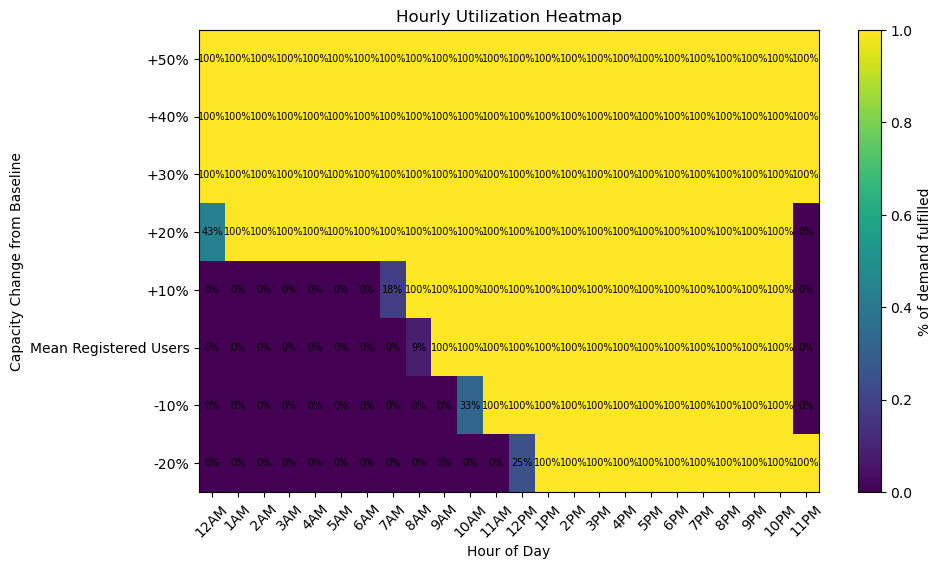

In [28]:
# Plotting heatmap changing capacities

heatmap_data = pd.DataFrame(
    index = capacity_labels,
    columns = range(24)
)

for label, cap in zip(capacity_labels, capacities):
    heatmap_data.loc[label] = bike_reuse_update(hourly_demand, cap)

utilization_data = heatmap_data.copy()

for h in range(24):
    utilization_data.iloc[:, h] = (utilization_data.iloc[:,h] / hourly_demand[h])

utilization_data = np.array(utilization_data, dtype = float)
plt.figure(figsize=(10,6))
plt.imshow(
    utilization_data,
    aspect = "auto",
    origin = "lower",
    vmin = 0,
    vmax = 1
)
cbar = plt.colorbar()
cbar.set_label("% of demand fulfilled")

plt.xticks(range(24), hour_labels, rotation =45)
plt.yticks(range(len(capacity_labels)), capacity_labels)
plt.xlabel("Hour of Day")
plt.ylabel("Capacity Change from Baseline")
plt.title("Hourly Utilization Heatmap")
for i in range(len(capacity_labels)):
    for j in range(24):
        value = utilization_data[i,j]
        plt.text(
            j,i,
            f"{value:.0%}",
            ha = "center",
            va = "center",
            fontsize = 7)

plt.show()


In [32]:
# Weather Multiplier for change in demand by weather

weather_multiplier = {
    1: 1.0,
    2: 0.85,
    3: 0.65,
    4: 0.4
}

df_hourly["weather_factor"] = df_hourly["weathersit"].map(weather_multiplier)

df_hourly["weather_adjusted_registered"] = (df_hourly["registered"] * df_hourly["weather_factor"])


In [34]:
# Hourly Demand Based on Weather

hourly_demand_weather = (df_hourly.groupby("hr")["weather_adjusted_registered"].mean())

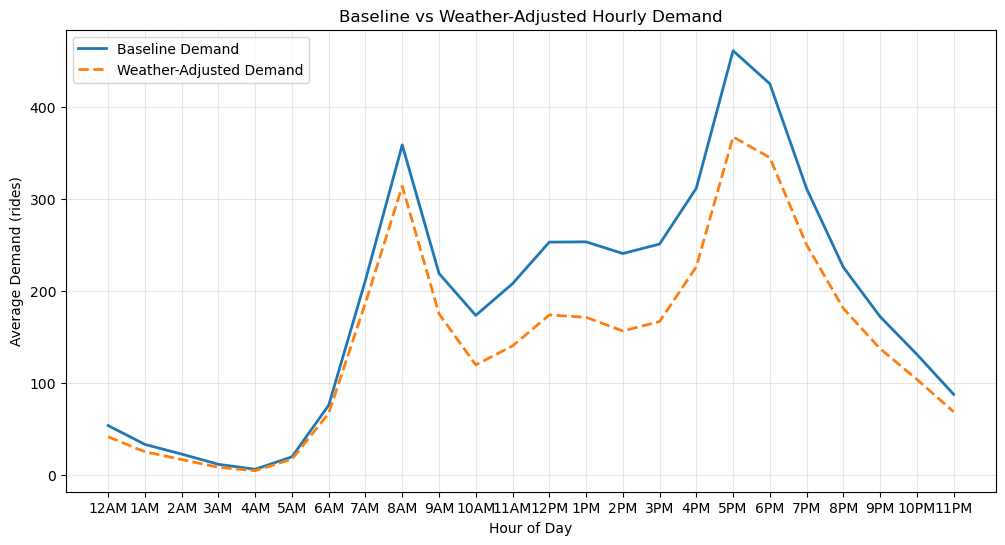

In [40]:
# Baseline Demand Vs Weather Adjusted Demand

plt.figure(figsize =(12,6))

plt.plot(
    hourly_demand.index,
    hourly_demand.values,
    label = "Baseline Demand",
    linewidth = 2
)

plt.plot(
    hourly_demand_weather.index,
    hourly_demand_weather.values,
    label = "Weather-Adjusted Demand",
    linewidth = 2,
    linestyle = "--"
)
plt.xlabel("Hour of Day")
plt.ylabel("Average Demand (rides)")
plt.title("Baseline vs Weather-Adjusted Hourly Demand")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

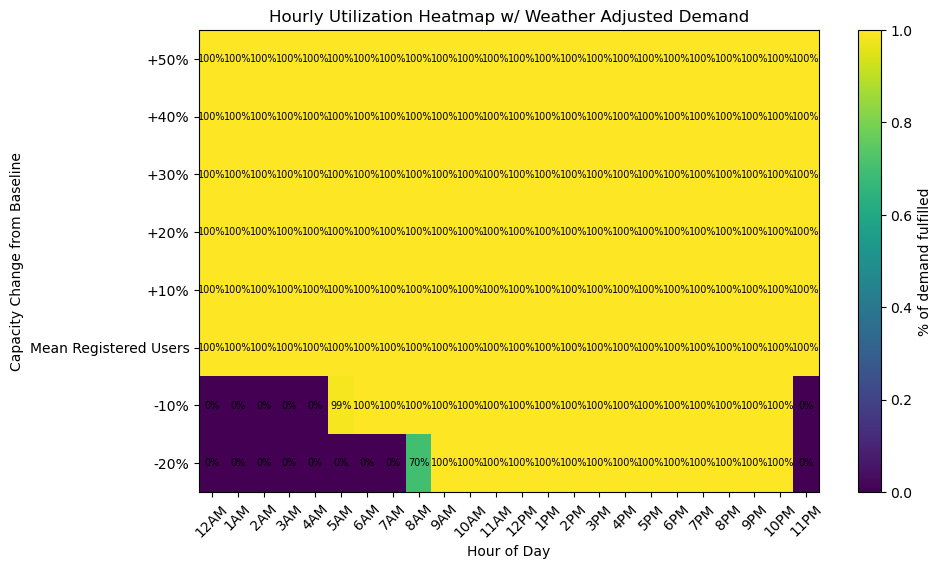

In [48]:
heatmap_data = pd.DataFrame(
    index = capacity_labels,
    columns = range(24)
)

for label, cap in zip(capacity_labels, capacities):
    heatmap_data.loc[label] = bike_reuse_update(hourly_demand_weather, cap)

utilization_data = heatmap_data.copy()

for h in range(24):
    utilization_data.iloc[:, h] = (utilization_data.iloc[:,h] / hourly_demand_weather[h])

utilization_data = np.array(utilization_data, dtype = float)
plt.figure(figsize=(10,6))
plt.imshow(
    utilization_data,
    aspect = "auto",
    origin = "lower",
    vmin = 0,
    vmax = 1
)
cbar = plt.colorbar()
cbar.set_label("% of demand fulfilled")

plt.xticks(range(24), hour_labels, rotation =45)
plt.yticks(range(len(capacity_labels)), capacity_labels)
plt.xlabel("Hour of Day")
plt.ylabel("Capacity Change from Baseline")
plt.title("Hourly Utilization Heatmap w/ Weather Adjusted Demand")
for i in range(len(capacity_labels)):
    for j in range(24):
        value = utilization_data[i,j]
        plt.text(
            j,i,
            f"{value:.0%}",
            ha = "center",
            va = "center",
            fontsize = 7)

plt.show()